In [1]:
# Import packages
import tensorflow.compat.v1 as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [3]:
# Disable the default activate eager execution in TF v1.0
tf.disable_eager_execution()

In [4]:
movies_df = pd.read_csv('./ml-25m/movies.csv')
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
#Loading in the ratings dataset
ratings_df = pd.read_csv('./ml-25m/ratings.csv')
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [6]:
movies_df['List Index'] = movies_df.index

In [7]:
merged_df = movies_df.merge(ratings_df, on='movieId')

In [8]:

merged_df = merged_df.drop('timestamp', axis=1).drop('title', axis=1).drop('genres', axis=1)

In [9]:
# Get user groups
userGroup = merged_df.groupby('userId')

In [10]:
def preprocess_data(userGroup, movies_df):
    """
    Format the data for input and output into the RBM
    :param userGroup: data frame that stores user groups
    :param movies_df: data frame that stores movies information
    :return: user ratings normalized into a list - trX
    """
    # No. of users in training
    UsedUsers = 1000
    # create list
    trX = []
    # for each user in the group
    for userID, curUser in userGroup:
        # Temp variable that stores every movie's rating
        temp = [0] * len(movies_df)
        # For Each movie in the curUser's movie list
        for num, movie in curUser.iterrows():
            # Divide ratings by 5 and store it
            temp[int(movie['List Index'])] = movie['rating'] / 5.0

        # Now add the list of ratings into the training list
        trX.append(temp)
        # Check to see if we finished adding in the amount of users for training
        if UsedUsers == 0:
            break
        UsedUsers -= 1
    return trX

In [11]:
# Return normalized user ratings into a list
trX = preprocess_data(userGroup, movies_df)

In [12]:
def rbm(movies_df):
    """
    Implement RBM architecture in TensorFlow
    :param movies_df: data frame that stores movies information
    :param config: variable to store hyper-parameters
    :return: variables to be used during TensorFlow training
    """
    n_hid = 100  # Number of hidden layers
    n_vis = len(movies_df)  # Number of visible layers

    # Create respective placeholder variables for storing visible and hidden layer biases and weights
    vb = tf.placeholder("float", [n_vis])  # Number of unique movies
    hb = tf.placeholder("float", [n_hid])  # Number of features
    W = tf.placeholder("float", [n_vis, n_hid])  # Weights that connect the hidden and visible layers

    # Pre-process the input data
    v0 = tf.placeholder("float", [None, n_vis])
    _h0 = tf.nn.sigmoid(tf.matmul(v0, W) + hb)
    h0 = tf.nn.relu(tf.sign(_h0 - tf.random_uniform(tf.shape(_h0))))

    # Reconstruct the pre-processed input data (Sigmoid and ReLU activation functions are used)
    _v1 = tf.nn.sigmoid(tf.matmul(h0, tf.transpose(W)) + vb)
    v1 = tf.nn.relu(tf.sign(_v1 - tf.random_uniform(tf.shape(_v1))))
    h1 = tf.nn.sigmoid(tf.matmul(v1, W) + hb)

    # Set RBM training parameters
    alpha = 0.1  # Set learning rate
    w_pos_grad = tf.matmul(tf.transpose(v0), h0)  # Set positive gradients
    w_neg_grad = tf.matmul(tf.transpose(v1), h1)  # Set negative gradients

    # Calculate contrastive divergence to maximize
    CD = (w_pos_grad - w_neg_grad) / tf.to_float(tf.shape(v0)[0])

    # Create methods to update the weights and biases
    update_w = W + alpha * CD
    update_vb = vb + alpha * tf.reduce_mean(v0 - v1, 0)
    update_hb = hb + alpha * tf.reduce_mean(h0 - h1, 0)

    # Set error function (RMSE)
    err = v0 - v1
    err_sum = tf.sqrt(tf.reduce_mean(err**2))

    # Initialize variables
    cur_w = np.zeros([n_vis, n_hid], np.float32)  # Current weight
    cur_vb = np.zeros([n_vis], np.float32)  # Current visible unit biases
    cur_hb = np.zeros([n_hid], np.float32)  # Current hidden unit biases
    prv_w = np.zeros([n_vis, n_hid], np.float32)  # Previous weight
    prv_vb = np.zeros([n_vis], np.float32)  # Previous visible unit biases
    prv_hb = np.zeros([n_hid], np.float32)  # Previous hidden unit biases

    return v0, W, vb, hb, update_w, prv_w, prv_vb, prv_hb, update_vb, update_hb, cur_w, cur_vb, cur_hb, err_sum


In [13]:
# Return variables from the RBM implementation
v0, W, vb, hb, update_w, prv_w, prv_vb, prv_hb, update_vb, update_hb, cur_w, cur_vb, cur_hb, err_sum = rbm(movies_df)

Instructions for updating:
Use `tf.cast` instead.


In [15]:
# Initialize TensorFlow session
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# Train RBM with 50 epochs and batches of size 512
nb_epoch = 50
batch_size_ = 512
errors = []

In [17]:
for i in range(nb_epoch):
    print("Current epoch: ", i)
    for start, end in zip(range(0, len(trX), batch_size_), range(batch_size_, len(trX), batch_size_)):
        batch = trX[start:end]
        cur_w = sess.run(update_w, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        cur_vb = sess.run(update_vb, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        cur_hb = sess.run(update_hb, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        prv_w = cur_w
        prv_vb = cur_vb
        prv_hb = cur_hb
    errors.append(sess.run(err_sum, feed_dict={v0: trX, W: cur_w, vb: cur_vb, hb: cur_hb}))
    print("Current RMSE error: ", errors[-1])

Current epoch:  0
Current RMSE error:  0.5803831
Current epoch:  1
Current RMSE error:  0.56735504
Current epoch:  2
Current RMSE error:  0.55335593
Current epoch:  3
Current RMSE error:  0.53943634
Current epoch:  4
Current RMSE error:  0.5237878
Current epoch:  5
Current RMSE error:  0.5077696
Current epoch:  6
Current RMSE error:  0.4902013
Current epoch:  7
Current RMSE error:  0.47001198
Current epoch:  8
Current RMSE error:  0.44803044
Current epoch:  9
Current RMSE error:  0.42565623
Current epoch:  10
Current RMSE error:  0.3989083
Current epoch:  11
Current RMSE error:  0.37095195
Current epoch:  12
Current RMSE error:  0.34233612
Current epoch:  13
Current RMSE error:  0.31543198
Current epoch:  14
Current RMSE error:  0.2954346
Current epoch:  15
Current RMSE error:  0.2822946
Current epoch:  16
Current RMSE error:  0.2747387
Current epoch:  17
Current RMSE error:  0.26864004
Current epoch:  18
Current RMSE error:  0.26454735
Current epoch:  19
Current RMSE error:  0.2621078

Text(0.5, 0, 'Number of Epochs')

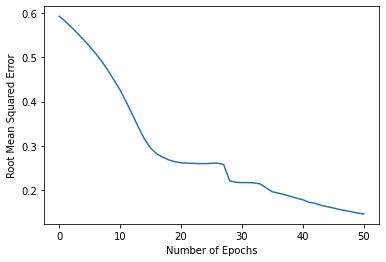

In [18]:
plt.plot(errors)
plt.ylabel('Root Mean Squared Error')
plt.xlabel('Number of Epochs')

In [19]:
# Selecting the input user
inputUser = [trX[1]]


In [20]:
# Feed in the user and reconstructing the input
hh0 = tf.nn.sigmoid(tf.matmul(v0, W) + hb)
vv1 = tf.nn.sigmoid(tf.matmul(hh0, tf.transpose(W)) + vb)
feed = sess.run(hh0, feed_dict={v0: inputUser, W: prv_w, hb: prv_hb})
rec = sess.run(vv1, feed_dict={hh0: feed, W: prv_w, vb: prv_vb})

In [22]:
# We can then list the 25 most recommended movies for our mock user by sorting it by their scores given by our model
scored_movies_df_850 = movies_df
scored_movies_df_850["Recommendation Score"] = rec[0]
print("\n")
scored_movies_df_850.sort_values(["Recommendation Score"], ascending=False).head(25)

,movieId,title,genres,List Index,Recommendation Score
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,1.0
5840,5952,"Lord of the Rings: The Two Towers, The (2002)",Adventure|Fantasy,5840,1.0
4122,4226,Memento (2000),Mystery|Thriller,4122,1.0
2670,2762,"Sixth Sense, The (1999)",Drama|Horror|Mystery,2670,1.0
1108,1136,Monty Python and the Holy Grail (1975),Adventure|Comedy|Fantasy,1108,1.0
2480,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller,2480,1.0
3479,3578,Gladiator (2000),Action|Adventure|Drama,3479,1.0
46,47,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,46,1.0
49,50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,49,1.0
1167,1197,"Princess Bride, The (1987)",Action|Adventure|Comedy|Fantasy|Romance,1167,1.0


In [29]:
print("\n")
print(merged_df.iloc[1])



movieId       1.0
List Index    0.0
userId        3.0
rating        4.0
Name: 1, dtype: float64


In [30]:
movies_df_850 = merged_df[merged_df['userId'] == 2562]

In [31]:
# We merge all the movies that our mock users has watched with the predicted scores based on his historical data
merged_df_850 = scored_movies_df_850.merge(movies_df_850, on='movieId', how='outer')
merged_df_850 = merged_df_850.drop('List Index_y', axis=1).drop('userId', axis=1)
print("\n")
merged_df_850.sort_values(["rating"], ascending=False).head(25)

,movieId,title,genres,List Index_x,Recommendation Score,rating
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,1.000000,5.0
522,527,Schindler's List (1993),Drama|War,522,1.000000,5.0
1666,1732,"Big Lebowski, The (1998)",Comedy|Crime,1666,0.412032,5.0
1707,1784,As Good as It Gets (1997),Comedy|Drama|Romance,1707,0.394056,5.0
1323,1358,Sling Blade (1996),Drama,1323,0.214283,5.0
1177,1208,Apocalypse Now (1979),Action|Drama|War,1177,0.409338,5.0
1120,1148,Wallace & Gromit: The Wrong Trousers (1993),Animation|Children|Comedy|Crime,1120,0.247624,5.0
903,924,2001: A Space Odyssey (1968),Adventure|Drama|Sci-Fi,903,0.435395,5.0
840,858,"Godfather, The (1972)",Crime|Drama,840,1.000000,5.0
769,785,Kingpin (1996),Comedy,769,0.161313,5.0


In [38]:
merged_df_850_non_na = merged_df_850.dropna()

In [39]:
X = merged_df_850_non_na['Recommendation Score'].values.reshape(-1, 1)
y = merged_df_850_non_na['rating'].values

In [40]:
from sklearn.linear_model import LinearRegression

In [41]:
# train linear regression model
model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [46]:
merged_df_850["PredictedRating"]=model.predict(merged_df_850[["Recommendation Score"]])

/Users/aryuska/.pyenv/versions/3.9.2/lib/python3.9/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


In [47]:
merged_df_850.sort_values(by='PredictedRating', ascending=False)

,movieId,title,genres,List Index_x,Recommendation Score,rating,PredictedRating
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,1.000000,5.0,4.404538
1168,1198,Raiders of the Lost Ark (Indiana Jones and the...,Action|Adventure,1168,1.000000,NaN,4.404538
359,364,"Lion King, The (1994)",Adventure|Animation|Children|Drama|Musical|IMAX,359,1.000000,NaN,4.404538
1232,1265,Groundhog Day (1993),Comedy|Fantasy|Romance,1232,1.000000,NaN,4.404538
372,377,Speed (1994),Action|Romance|Thriller,372,1.000000,NaN,4.404538
...,...,...,...,...,...,...,...
15941,84150,"Prowler, The (1951)",Drama|Film-Noir|Thriller,15941,0.011839,NaN,3.424624
31524,138814,Dead Innocent (1997),Horror|Thriller,31524,0.011780,NaN,3.424566
32627,141375,Sugarhouse (2007),Drama|Thriller,32627,0.011769,NaN,3.424555
21815,112395,Belle Starr (1941),Western,21815,0.011672,NaN,3.424459
